In [1]:
ref = 'data4/ref/0003.png' # path to reference image
cam = 'data4/cam/0003.png' # path to camera image

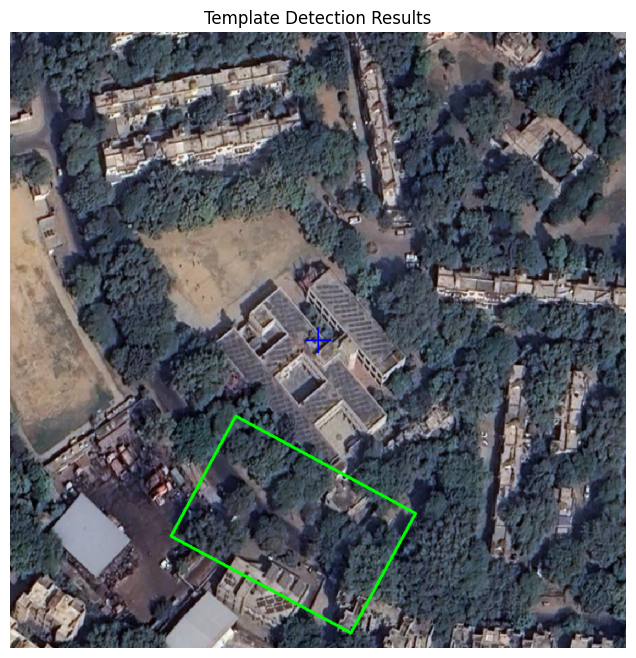

Reference center: (500, 500)
Center coordinates (X+ down, Y+ right): (299, -39)
Rotation angle: 28.32°


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_template_location(reference_path, template_path):
    # Load images
    reference = cv2.imread(reference_path)
    template = cv2.imread(template_path)
    
    if reference is None or template is None:
        raise ValueError("Failed to load images")
    
    # Get reference dimensions and center
    ref_height, ref_width = reference.shape[:2]
    ref_center = (ref_width // 2, ref_height // 2)  # (x, y) format
    
    # Convert to grayscale
    ref_gray = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)
    tpl_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    
    # Find keypoints and descriptors
    kp_ref, desc_ref = sift.detectAndCompute(ref_gray, None)
    kp_tpl, desc_tpl = sift.detectAndCompute(tpl_gray, None)
    
    if desc_ref is None or desc_tpl is None:
        raise ValueError("No features detected in images")
    
    # FLANN matcher
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Match descriptors
    matches = flann.knnMatch(desc_tpl, desc_ref, k=2)
    
    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    
    if len(good_matches) < 10:
        raise ValueError("Insufficient good matches found")
    
    # Get matched points
    src_pts = np.float32([kp_tpl[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp_ref[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
    
    # Find homography with RANSAC
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    if M is None:
        raise ValueError("Homography matrix could not be computed")
    
    # Get template dimensions
    h, w = tpl_gray.shape
    
    # Create template corners
    template_corners = np.float32([[0,0], [0,h-1], [w-1,h-1], [w-1,0]]).reshape(-1,1,2)
    
    # Transform corners to reference image space
    ref_corners = cv2.perspectiveTransform(template_corners, M)
    
    # Calculate center coordinates relative to reference center
    mean_x = np.mean(ref_corners[:,:,0])
    mean_y = np.mean(ref_corners[:,:,1])
    center_x = mean_y - ref_center[1]  # X = y - center_y (down +)
    center_y = mean_x - ref_center[0]  # Y = x - center_x (right +)
    
    # Calculate rotation angle using top edge vector
    tl_img = ref_corners[0][0]  # Top-left in image coordinates (x, y)
    tr_img = ref_corners[3][0]  # Top-right in image coordinates (x, y)
    
    deltaY = tr_img[0] - tl_img[0]  # Change in image x (Y in user's system)
    deltaX = tr_img[1] - tl_img[1]  # Change in image y (X in user's system)
    angle_rad = np.arctan2(deltaX, deltaY)
    angle_deg = np.degrees(angle_rad)
    angle_deg = np.mod(angle_deg, 360)  # Normalize to 0-360 degrees
    
    # Prepare visualization
    result = reference.copy()
    
    # Draw reference center crosshair
    cv2.drawMarker(result, ref_center, (255,0,0), markerType=cv2.MARKER_CROSS, 
                   markerSize=40, thickness=2)
    
    # Draw bounding box
    cv2.polylines(result, [np.int32(ref_corners)], True, (0,255,0), 3)
    
    # Convert to RGB for display
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    # Display results
    plt.figure(figsize=(12, 8))
    plt.imshow(result_rgb)
    plt.axis('off')
    plt.title("Template Detection Results")
    plt.show()
    
    return {
        'center_relative': (int(center_x), int(center_y)),
        'corners_relative': [(int(y - ref_center[1]), int(x - ref_center[0])) 
                            for x, y in ref_corners.squeeze().tolist()],
        'rotation_angle': angle_deg,
        'reference_center': ref_center,
        'corners_absolute': ref_corners.squeeze().tolist()
    }

# Usage example
try:
    result = find_template_location(ref, cam)
    print("Reference center:", result['reference_center'])
    print("Center coordinates (X+ down, Y+ right):", result['center_relative'])
    print(f"Rotation angle: {result['rotation_angle']:.2f}°")
except Exception as e:
    print(f"Error: {e}")
